In [108]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

# for feature selection
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [146]:
infile = "calval_regression_data.p"
outfile = 'model_feature_selection.xlsx'
remove = 'thedonald'
SCORING_METHOD = 'roc_auc'
X_COLS = [
    'sentiment_sign', 'sentiment_magnitude', 'post_activity_count',
    'comment_activity_count'
    ]
Y_COL = 'success'



In [137]:
def logit_forward_sequential_selection(X, y, test=True, name=''):
    if test:
        X_train = X['calibration']
        X_test = X['validation']
        y_train = y['calibration']
        y_test = y['validation']
    else:
        X_train = X
        y_train = y
    
    max_k = len(X_train.columns)
    k=(1, max_k)

    sfs = SequentialFeatureSelector(
        linear_model.LogisticRegression(),
        k_features = k,
        forward=True,
        scoring=scoring_method,
        cv=None,
        )
    
    selected_features = sfs.fit(X_train, y_train)
    print(f'selected features: {selected_features.k_feature_names_}')
    metric_df = pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index')
    display(metric_df)

    if test:
        # Generate the new subsets based on the selected features
        # Note that the transform call is equivalent to
        # X_train[:, sfs1.k_feature_idx_]
        X_train_sfs = selected_features.transform(X_train)
        X_test_sfs = selected_features.transform(X_test)

        # Fit the estimator using the new feature subset
        # and make a prediction on the test data
        logit = linear_model.LogisticRegression()
        logit.fit(X_train_sfs, y_train)
        y_pred = logit.predict(X_test_sfs)

        # Compute the accuracy of the prediction
        acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
        print('Test set accuracy: %.2f %%' % (acc * 100))

        # Compute the AUC of the prediction
        auc = metrics.roc_auc_score(y_test,  y_pred)
        print('Test set ROC AUC: %.2f' % (auc))
    

    fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
    plt.title(f'{name} Sequential Forward Selection (w. StdDev)')
    plt.ylabel('Performance - roc auc')
    plt.show()
    results = {
        'metric_df': metric_df,
        'selected_features': selected_features.k_feature_names_,
        'test_set_accuracy': acc,
        'test_set_auc': auc
    }
    return results

In [100]:
regression_thread_data = pickle.load(open(infile, 'rb'))
if remove:
    regression_thread_data.pop(remove)


### books ###
selected features: ('post_activity_count', 'comment_activity_count')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.766268109407875],0.766268,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7796964232040878],0.779696,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.7786245867147581],0.778625,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.7639901813445547],0.763990,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 73.55 %
Test set ROC AUC: 0.57


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


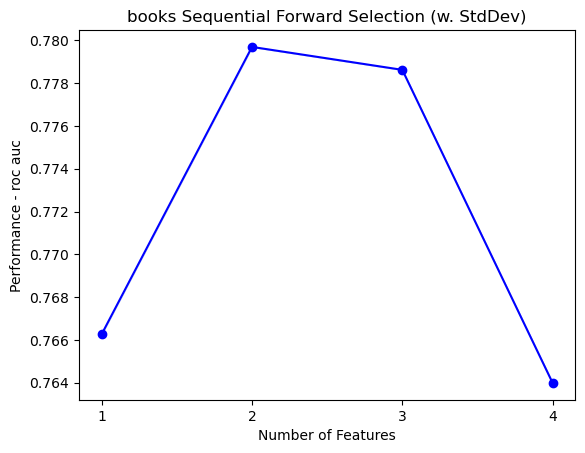


### conspiracy ###
selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.7774060348014974],0.777406,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7387578641331977],0.738758,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(0, 2, 3)",[0.7259214780622698],0.725921,"(sentiment_sign, post_activity_count, comment_...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.710981370164533],0.710981,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 85.73 %
Test set ROC AUC: 0.50


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


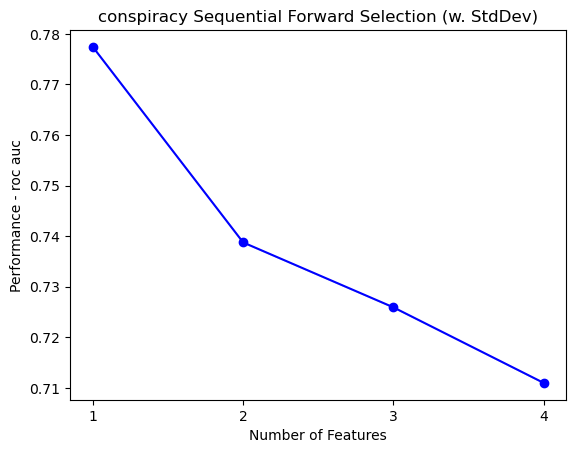


### crypto ###
selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 63.92 %
Test set ROC AUC: 0.58


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


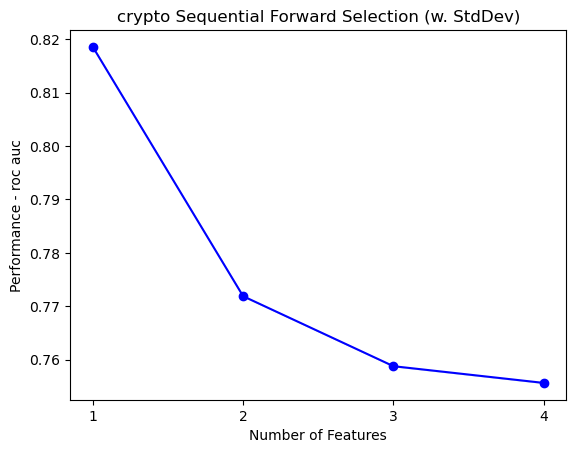


### politics ###
selected features: ('post_activity_count', 'comment_activity_count')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.7082103674819289],0.708210,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7146160205472986],0.714616,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.6956303789405782],0.695630,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.6892019986014861],0.689202,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 67.31 %
Test set ROC AUC: 0.50


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


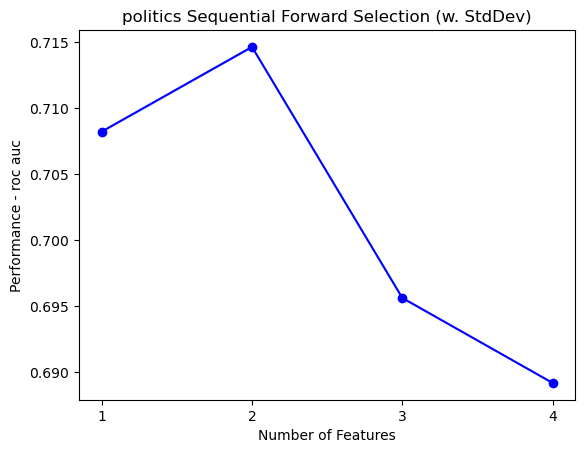

In [138]:
FSS_metrics = {}
for key in regression_thread_data:
    print(f'\n### {key} ###')
    X = {}
    y = {}
    for calval in regression_thread_data[key]:
        X[calval] = regression_thread_data[key][calval][X_COLS]
        y[calval] = regression_thread_data[key][calval][Y_COL]
    FSS_metrics[key] = logit_forward_sequential_selection(X, y, name=key)

In [139]:
FSS_metrics

{'books': {'metric_df':     feature_idx             cv_scores  avg_score  \
  1          (3,)   [0.766268109407875]   0.766268   
  2        (2, 3)  [0.7796964232040878]   0.779696   
  3     (1, 2, 3)  [0.7786245867147581]   0.778625   
  4  (0, 1, 2, 3)  [0.7639901813445547]   0.763990   
  
                                         feature_names  ci_bound  std_dev  \
  1                          (comment_activity_count,)       NaN      0.0   
  2      (post_activity_count, comment_activity_count)       NaN      0.0   
  3  (sentiment_magnitude, post_activity_count, com...       NaN      0.0   
  4  (sentiment_sign, sentiment_magnitude, post_act...       NaN      0.0   
  
     std_err  
  1      NaN  
  2      NaN  
  3      NaN  
  4      NaN  ,
  'selected_features': ('post_activity_count', 'comment_activity_count'),
  'test_set_accuracy': 0.735519888346127,
  'test_set_auc': 0.5712111962111962},
 'conspiracy': {'metric_df':     feature_idx             cv_scores  avg_score  \
  1  

In [142]:
i = 0
other_feats_dict = {}
for key in FSS_metrics:
    df = FSS_metrics[key]['metric_df'][['feature_idx', 'cv_scores', 'avg_score', 'feature_names']].reset_index().rename(columns={'index': 'number_features'})
    df.loc[:,'subreddit'] = key
    if i == 0:
        FSS_metrics_df = df
        i += 1
    else:
        FSS_metrics_df = pd.concat((FSS_metrics_df, df))
    FSS_metrics[key].pop('metric_df')

FSS_metrics_df


,number_features,feature_idx,cv_scores,avg_score,feature_names,subreddit
0,1,"(3,)",[0.766268109407875],0.766268,"(comment_activity_count,)",books
1,2,"(2, 3)",[0.7796964232040878],0.779696,"(post_activity_count, comment_activity_count)",books
2,3,"(1, 2, 3)",[0.7786245867147581],0.778625,"(sentiment_magnitude, post_activity_count, com...",books
3,4,"(0, 1, 2, 3)",[0.7639901813445547],0.763990,"(sentiment_sign, sentiment_magnitude, post_act...",books
0,1,"(3,)",[0.7774060348014974],0.777406,"(comment_activity_count,)",conspiracy
1,2,"(2, 3)",[0.7387578641331977],0.738758,"(post_activity_count, comment_activity_count)",conspiracy
2,3,"(0, 2, 3)",[0.7259214780622698],0.725921,"(sentiment_sign, post_activity_count, comment_...",conspiracy
3,4,"(0, 1, 2, 3)",[0.710981370164533],0.710981,"(sentiment_sign, sentiment_magnitude, post_act...",conspiracy
0,1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",crypto
1,2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",crypto


In [135]:
FSS_metrics_df.set_index(['subreddit', 'number_features'], inplace=True)

,number_features,feature_idx,cv_scores,avg_score,feature_names,subreddit
0,1,"(3,)",[0.7082103674819289],0.708210,"(comment_activity_count,)",politics
1,2,"(2, 3)",[0.7146160205472986],0.714616,"(post_activity_count, comment_activity_count)",politics
2,3,"(1, 2, 3)",[0.6956303789405782],0.695630,"(sentiment_magnitude, post_activity_count, com...",politics
3,4,"(0, 1, 2, 3)",[0.6892019986014861],0.689202,"(sentiment_sign, sentiment_magnitude, post_act...",politics


In [136]:
FSS_metrics_df

feature_idx             cv_scores  avg_score  \
subreddit  number_features                                                  
books      1                        (3,)   [0.766268109407875]   0.766268   
           2                      (2, 3)  [0.7796964232040878]   0.779696   
           3                   (1, 2, 3)  [0.7786245867147581]   0.778625   
           4                (0, 1, 2, 3)  [0.7639901813445547]   0.763990   
conspiracy 1                        (3,)  [0.7774060348014974]   0.777406   
           2                      (2, 3)  [0.7387578641331977]   0.738758   
           3                   (0, 2, 3)  [0.7259214780622698]   0.725921   
           4                (0, 1, 2, 3)   [0.710981370164533]   0.710981   
crypto     1                        (3,)  [0.8185895728905598]   0.818590   
           2                      (2, 3)  [0.7718789719835302]   0.771879   
           3                   (1, 2, 3)   [0.758764116392171]   0.758764   
           4                (0, 1, 2, 3)  [0.7556305197517603]   0.755631   
politics   1                        (3,)  [0.7082103674819289]   0.708210   
           2                      (2, 3)  [0.7146160205472986]   0.714616   
           3                   (1, 2, 3)  [0.6956303789405782]   0.695630   
           4                (0, 1, 2, 3)  [0.6892019986014861]   0.689202   

                                                                feature_names  
subreddit  number_features                                                     
books      1                                        (comment_activity_count,)  
           2                    (post_activity_count, comment_activity_count)  
           3                (sentiment_magnitude, post_activity_count, com...  
           4                (sentiment_sign, sentiment_magnitude, post_act...  
conspiracy 1                                        (comment_activity_count,)  
           2                    (post_activity_count, comment_activity_count)  
           3                (sentiment_sign, post_activity_count, comment_...  
           4                (sentiment_sign, sentiment_magnitude, post_act...  
crypto     1                                        (comment_activity_count,)  
           2                    (post_activity_count, comment_activity_count)  
           3                (sentiment_magnitude, post_activity_count, com...  
           4                (sentiment_sign, sentiment_magnitude, post_act...  
politics   1                                        (comment_activity_count,)  
           2                    (post_activity_count, comment_activity_count)  
           3                (sentiment_magnitude, post_activity_count, com...  
           4                (sentiment_sign, sentiment_magnitude, post_act...

In [147]:
other_metrics = pd.DataFrame.from_dict(FSS_metrics).T
other_metrics

,selected_features,test_set_accuracy,test_set_auc
books,"(post_activity_count, comment_activity_count)",0.73552,0.571211
conspiracy,"(comment_activity_count,)",0.857268,0.5
crypto,"(comment_activity_count,)",0.639226,0.577792
politics,"(post_activity_count, comment_activity_count)",0.67306,0.5


In [148]:
with pd.ExcelWriter(outfile, engine='xlsxwriter') as writer:
    FSS_metrics_df.to_excel(writer, sheet_name='FSS_metrics')
    other_metrics.to_excel(writer, sheet_name='test_sets')